In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive

## Clone source code về (Paddle OCR)

In [ ]:
# !mkdir Scene_TextVN
%cd /content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese
# !git clone https://github.com/PaddlePaddle/PaddleOCR

/content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese


### Cài đặt thư viện cần thiết 

In [ ]:
!pip install -r requirements.txt

     |████████████████████████████████| 12.5 MB 35.1 MB/s 
     |████████████████████████████████| 948 kB 58.8 MB/s 
     |████████████████████████████████| 603 kB 65.8 MB/s 
     |████████████████████████████████| 2.7 MB 70.0 MB/s 
     |████████████████████████████████| 50 kB 8.6 MB/s 
     |████████████████████████████████| 55.7 MB 1.2 MB/s 
     |████████████████████████████████| 199 kB 70.4 MB/s 
     |████████████████████████████████| 2.1 MB 72.1 MB/s 
     |████████████████████████████████| 127 kB 77.3 MB/s 
     |████████████████████████████████| 64 kB 3.4 MB/s 
     |████████████████████████████████| 69 kB 10.7 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 404 kB 75.3 MB/s 
     |████████████████████████████████| 2.0 MB 69.9 MB/s 
     |████████████████████████████████| 98 kB 10.1 MB/s 
     |████████████████████████████████| 596 kB 69.9 MB/s 
     |████████████████████████████████| 8.8 MB 56.6 MB/s 
     |███████████████

In [ ]:
!pip install paddlepaddle-gpu 

     |████████████████████████████████| 576.1 MB 9.9 kB/s 
     |████████████████████████████████| 373 kB 76.3 MB/s 


In [ ]:
!nvidia-smi

Thu May 19 14:16:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Cả hai phần ***detect*** và ***recognize*** đều gồm các bước sau:

Bước 1: Tiền xử lý dữ liệu <br>
Bước 2: Cấu hình file config <br>
Bước 3: Train model <br>
Bước 4: Evaluation <br>
Bước 5: Convert sang model inference <br>
Bước 6: Predict <br>

In [ ]:
# !python3 ConvertFromBtcToFormatPaddle.py

## Model Detection (SAST)

SAST (A Single-Shot Arbitrarily-Shaped Text Detector based on Context Attended Multi-Task Learning) là một mô hình hiệu quả trong việc dự đoán văn bản có hình dạng tùy ý tuy nhiên các vùng chữ nhỏ đang là vấn đề với nó.

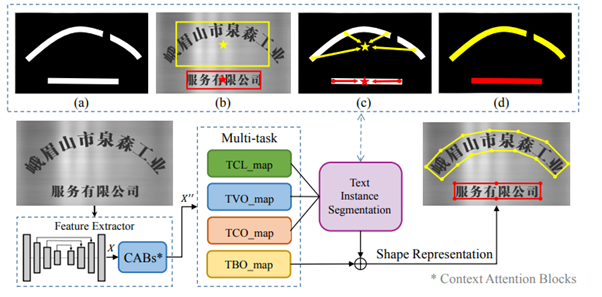

### Chuẩn bị dữ liệu

Bạn có thể tập dữ liệu huấn luyện từ repo https://github.com/VinAIResearch/dict-guided và download dataset Original với format x1,y1,x2,y2,x3,y3,x4,y4,TRANSCRIPT.

Sau khi tải về và giải nén nó ra chúng ta sẽ có:

* Folder labels – chứa các file annotation của từng image
* Folder train_images – chứa 1200 ảnh  từ im0001 đến im1200
* Folder test_image – chứa 300 ảnh từ im1201 đến 1500
* Folder unseen_test_images – chứa 500 ảnh từ im1501 đến im2000
* File general_dict.txt
* File vn_dictionary.txt

In [ ]:
# !gdown --id 1UUQhNvzgpZy7zXBFQp0Qox-BBjunZ0ml
# !unzip vietnamese_original.zip -d train

### Tiền xử lý dữ liệu, convert về format của PaddleOCR để train:

Để train model detection PaddleOCR, file annotation cần có format như sau:



> Image file name_____________Image annotation information encoded by json.dumps”

> img_001.jpg_________________[{“transcription”: “text”, “points”: [[310, 104], [416, 141], [418, 216], [312, 179]]}, {…}]



Ở đây
* points sẽ là các cặp (x, y) 4 góc của text box theo chiều ngược kim đồng hồ, bắt đầu từ góc dưới bên trái.
* transcription là text ở trong text box hiện tại. Khi chứa “###” thì có nghĩa là text box này invalid và sẽ skip đi khi train model.

Quan sát tập dữ liệu ta thấy:
* Folder labels chứa từng file annotation cho mỗi ảnh.
* Mỗi dòng trong file annotation chứa một text box.
* Các cặp points được xếp theo chiều ngược kim đồng hồ và bắt đầu từ góc dưới bên trên và tách nhau bởi dấu phẩy, cuối cùng là text của box đó.


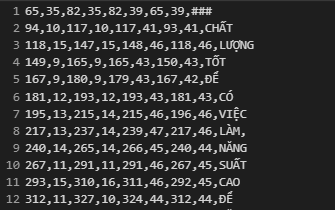

Ý tưởng để convert về format PaddleOCR:
* Dùng một vòng lặp for đọc từng file annotation của mỗi ảnh.
* Chạy một vòng lặp for đọc các dòng trong file annotation cho đến hết để lấy các text box.
* Dùng split(‘,’, 8) để tách từng point và text ra sau đó lưu vào dictionary (trong lệnh split thêm tham số 8 để tránh trường hợp text chứa dấu phẩy sẽ bị thiếu dấu phẩy trong text).

In [ ]:
import glob 
import os
import numpy as np 
from tqdm import tqdm 
import pandas as pd  
import json

root_path = glob.glob('/content/drive/MyDrive/Scene_TextVN/train/vietnamese/labels/*')
train_label = open("train_label.txt","w")
test_label = open("test_label.txt","w")
useen_label = open("useen_label.txt","w")
for file in root_path:
    with open(file) as f:
      content = f.readlines()
      f.close()
    content = [x.strip() for x in content]
    text = []
    for i in content:
      label = {}
      i = i.split(',',8)
      label['transcription'] = i[-1]
      label['points'] = [[i[0],i[1]],[i[2],i[3]], [i[4],i[5]],[i[6],i[7]]]
      text.append(label)
    content = []
    text = json.dumps(text, ensure_ascii=False)
    img_name = os.path.basename(file).split('.')[0].split('_')[1]
    int_img = int(img_name)
    img_name = 'im' + "{:04n}".format(int(img_name)) + '.jpg'
    if int_img > 1500:
      useen_label.write( img_name+ '\t'+f'{text}' + '\n')
    elif int_img > 1200:
      test_label.write( img_name+ '\t'+f'{text}' + '\n')
    else:
      train_label.write( img_name+ '\t'+f'{text}' + '\n')

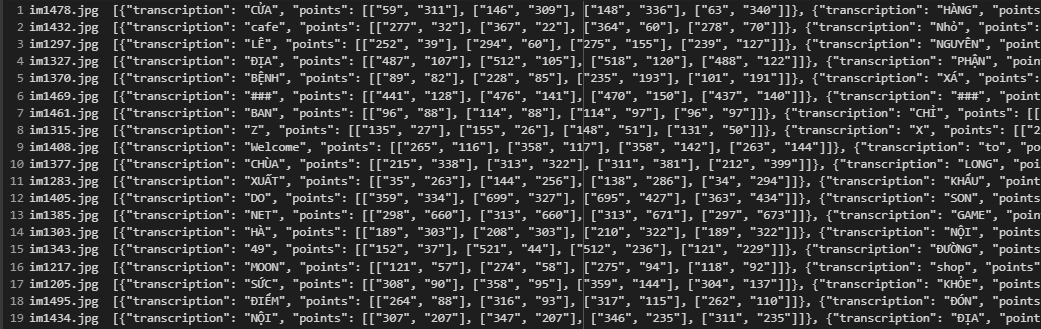

### Chuẩn bị file config

Trong bước này chọn model detection để sử dụng. 

SAST đạt hiệu quả tốt nhất cho nên sử dụng SAST với Backbone là ResNet50_vd trong cuộc thi này.

Sau khi quyết định được mô hình sẽ sử dụng, download pretrained model đã được train sẵn với dataset tiếng anh đạt kết quả cao với ICDAR2015 dataset.

Download Pretrained Model

Vào link sau đây và download pretrained SAST + ResNet50_vd:
https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/doc/doc_en/algorithm_overview_en.md

### Download pretrain model SAST


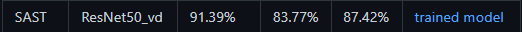

In [ ]:
# !wget https://paddleocr.bj.bcebos.com/dygraph_v2.0/en/det_r50_vd_sast_icdar15_v2.0_train.tar -P ./pretrain_models
# !tar -xf ./pretrain_models/det_r50_vd_sast_icdar15_v2.0_train.tar -C /content/drive/MyDrive/Scene_TextVN/pretrain_models

### Traning

In [ ]:
# %cd /content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese/

In [ ]:
# !python3 tools/train.py -c ./configs/det/SAST.yml

Chú thích

Global:
* use_gpu: sử dụng gpu hoặc không
* epoch_num: số epoch tối đa khi train .
* save_model_dir: là đường dẫn thư mục lưu checkpoint cho mỗi epoch khi train.
* pretrained_model: là đường dẫn thư mục pretrained model.
* checkpoints: là đường dẫn thư mục load checkpoint khi train.

Train:
* data_dir: là đường dẫn thư mục chứa ảnh train
* label_file_list: list các file annotation
* ratio_list: tỉ lệ train data set



---



Trong dòng code trên, sử dụng -c để chọn file cấu hình. Ngoài ra bạn còn có thể sử dụng -o để thay đổi các parameter mà không cần phải sửa file yml.

Sau mỗi save_epoch_step, checkpoint sẽ được lưu ở đường dẫn được đặt tại dòng Global.save_model_dir trong file config gồm 3 file:

* iter_epoch_1.pdopt
* iter_epoch_1.pdparams
* iter_epoch_1.states

Ví dụ ta có thể train tiếp từ checkpoint trên mà không cần sửa file config bằng cách sau:

In [ ]:
!python3 tools/train.py -c ./configs/det/SAST.yml    \
    -o Global.checkpoints=./output/SAST/iter_epoch_26

Chú thích: Global.checkpoints sẽ được ưu tiên hơn Global.pretrained_model do đó nếu cả 2 đều được set thì Global.checkpoints sẽ được load để train. Nếu đường dẫn Global.checkpoints sai, Global.pretrained_model sẽ được load.

## Model Recognition (SRN)

SRN (Semantic Reasoning Network) kết hợp cả phần visual information và global semantic information, hai phần này chạy song song trong quá trình huấn luyện và đưa ra kết quả.

SRN là một end-to-end trainable pipeline cho bài toán scene text recognition, bao gồm 4 phần:

* Backbone network
* Parallel visual attention module (PVAM)
* Global semantic reasoning module (GSRM)
* Visual semantic fusion decoder (VSFD)

Pipeline: Khi đưa ảnh đầu vào, đầu tiên, backbone network sẽ được dùng để trích xuất các thuộc tính 2D (V). Sau đó, PVAM được dùng để tạo ra N thuộc tính 1D sau khi được căn chỉnh, tại đó, mỗi thuộc tính tương ứng với một ký tự trong văn bản. N thuộc tính 1D này sau đó sẽ được đưa vào GSRM để thu thập thông tin ngữ nghĩa (S). Cuối cùng, các thuộc tính ảnh sau khi được căn chỉnh và ngữ nghĩa của nó sẽ được VSFD hợp nhất để dự đoán các ký tự.

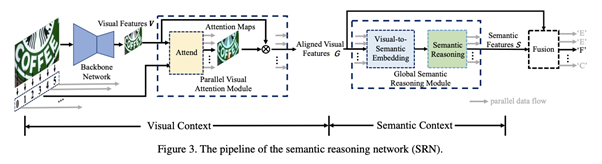

### Chuẩn bị dữ liệu

Data train model recognition thì nó sẽ khác so với model detection đó là data sẽ là các ảnh nhỏ và một file txt lưu đường dẫn ảnh cùng với chữ trong ảnh đó.

Format data

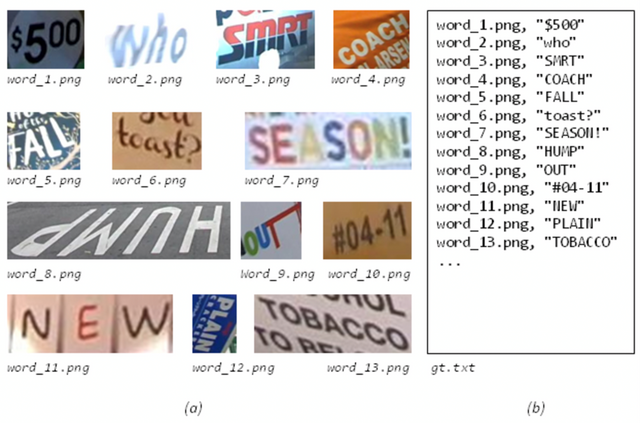

Có thể thấy rằng data để train model recognition là mỗi ảnh chứa một chữ trong khi data đã download lại là ảnh chứa nhiều chữ. Do vậy ta phải cắt nhỏ ảnh đã có từ các box chứa text.

In [ ]:
%cd /content/drive/MyDrive/Scene_TextVN/

/content/drive/MyDrive/Scene_TextVN


In [ ]:
!mkdir ./train/img_crop

In [ ]:
import json
import os
import cv2
import copy
import numpy as np
from tools.infer.utility import draw_ocr_box_txt, get_rotate_crop_image

def print_draw_crop_rec_res( img_crop_list, img_name):
        bbox_num = len(img_crop_list)
        for bno in range(bbox_num):
          crop_name=img_name+'_'+str(bno)+'.jpg'
          crop_name_w = "/content/drive/MyDrive/Scene_TextVN/train/img_crop/{}".format(crop_name)
          cv2.imwrite(crop_name_w, img_crop_list[bno])
          crop_label.write("{0}\t{1}\n".format(crop_name, text[bno]))

crop_label = open('/content/drive/MyDrive/Scene_TextVN/train/vietnamese/crop_label.txt','w')

with open('/content/drive/MyDrive/Scene_TextVN/train_label.txt','r') as file_text:
  img_files=file_text.readlines()
count=0

for img_file in img_files:
  content = json.loads(img_file.split('\t')[1].strip())
  dt_boxes=[]
  text=[]
  for i in content:
    content = i['points']
    if i['transcription'] == "###":
      count+=1
      continue
    bb = np.array(i['points'],dtype=np.float32)
    dt_boxes.append(bb)
    text.append(i['transcription'])
  image_file = '/content/drive/MyDrive/Scene_TextVN/train/vietnamese/train_images/' +img_file.split('\t')[0]
  img = cv2.imread(image_file)
  ori_im=img.copy()
  img_crop_list=[]
  for bno in range(len(dt_boxes)):
    tmp_box = copy.deepcopy(dt_boxes[bno])
    img_crop = get_rotate_crop_image(ori_im, tmp_box)
    img_crop_list.append(img_crop)
  img_name = img_file.split('\t')[0].split('.')[0]
  print_draw_crop_rec_res(img_crop_list,img_name)

In [ ]:
!python3 /content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese/crop_image.py

### Dictionary

Để dự đoán được tiếng việt thì ta cũng cần một file dictionary dành cho tiếng Việt chứa tất cả các kí tự. Vì PaddleOCR chưa hỗ trợ tiếng Việt nên phải tự làm một file dictionary riêng để train. Dictionary được lưu ở ppocr/utils/dict/vi_vietnam.txt.

### Chuẩn bị file config

Cách chỉnh sửa file config model recognition cũng tương tự như model detection. Chỉ có một số điểm khác là character_dict_path – đường dẫn file dictionary,   use_space_char – dự đoán khoảng trắng hay không, max_text_length – độ dài tối đa kí tự trong một box.

### Training

In [ ]:
# !python3 tools/train.py -c ./configs/rec/SRN.yml \
#            -o Global.use_gpu=True \
#            Global.pretrained_model=pretrained_model \ 
#            Global.character_type = ch 

In [ ]:
!python3 tools/train.py -c ./configs/rec/SRN.yml 

## Evaluation

Một bước không thể thiếu đó là đánh giá mô hình để biết mô hình có đang hoạt động tốt không, chuyện gì xảy ra với mô hình. Từ đó giúp ta xác định được nên làm gì tiếp theo. Dataset dùng để evaluation được set ở mục Eval.dataset trong file config.

In [ ]:
#evaluation model detect 
!python3 /content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese/tools/eval.py -c /content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese/configs/det/SAST.yml \
                       -o Global.checkpoints_model=path_checkpoints

In [ ]:
#evaluation model recognition
!python3 /content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese/tools/eval.py -c /content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese/configs/rec/SRN.yml  \
                   -o Global.checkpoints=path_checkpoints \
                      Global.character_type=ch  \
                       Global.character_dict_path=/content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese/ppocr/utils/dict/vi_vietnam.txt  

##  Inference với model đã train xong

Cả 2 model detection và recognition được convert như sau:

In [ ]:
# !python3 tools/export_model.py -c ./configs/det/SAST.yml  \
#                               -o Global.pretrained_model= #path_pretrained \
#                                  Global.save_inference_dir=./inference/SAST

In [ ]:
# !python3 tools/export_model.py -c ./configs/rec/SRN.yml  \
#                               -o Global.pretrained_model= #path_pretrained \
#                                  Global.save_inference_dir=./inference/SRN

In [ ]:
!python3 /content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese/tools/infer/predict_det.py --det_algorithm="SAST" --use_gpu=True \
                                   --det_model_dir="/content/drive/MyDrive/Scene_TextVN/inference/SAST"  \
                                   --image_dir=/content/drive/MyDrive/Scene_TextVN/train/vietnamese/test_image/

In [ ]:
!python3 /content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese/tools/infer/predict_rec.py --image_dir="/content/drive/MyDrive/Scene_TextVN/train/vietnamese/test_image/im1201.jpg" \
                             --use_gpu=True \
                                   --rec_algorithm="SRN" \
                                   --rec_model_dir="/content/drive/MyDrive/Scene_TextVN/inference/SRN/"  \
                                   --rec_image_shape="1, 64, 256"  \
                                   --rec_char_type="ch"   \
                                   --rec_char_dict_path="/content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese/ppocr/utils/dict/vi_vietnam.txt"

In [ ]:
# infer rec
!python3 /content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese/tools/infer_rec.py -c /content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese/configs/rec/SRN.yml -o Global.pretrained_model=/content/drive/MyDrive/Scene_TextVN/pretrain_models/rec_r50_vd_srn_train/best_accuracy Global.load_static_weights=false Global.infer_img=/content/drive/MyDrive/Scene_TextVN/train/img_crop/im0004_4.jpg

### Kết hợp hai model detection và recognition với nhau:

Cuối cùng kết hợp cả hai model detection và recognition với nhau để predict ra kết quả:

In [ ]:
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

In [ ]:
%cd /content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese/

/content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese


In [ ]:
!python3 /content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese/tools/infer/predict_system.py --use_gpu=True  \
           --det_algorithm="SAST"  \
           --det_model_dir="/content/drive/MyDrive/Scene_TextVN/inference/SAST"  \
           --rec_algorithm="SRN" \
           --rec_model_dir="/content/drive/MyDrive/Scene_TextVN/inference/SRN/"  \
           --rec_image_shape="1, 64, 256"  \
           --image_dir="/content/test.jpg" \
           --rec_char_type="ch"  \
           --drop_score=0.7  \
           --rec_char_dict_path="/content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese/ppocr/utils/dict/vi_vietnam.txt" 

/usr/local/lib/python3.7/dist-packages/skimage/data/__init__.py:107: DeprecationWarning: 
    Importing file_hash from pooch.utils is DEPRECATED. Please import from the
    top-level namespace (`from pooch import file_hash`) instead, which is fully
    backwards compatible with pooch >= 0.1.
    
  return file_hash(path) == expected_hash
/usr/local/lib/python3.7/dist-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/usr/local/lib/python3.7/dist-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional